# `moscot-lineage` on simulated trajectories

This example is inspired by LineageOT[1] [`simulation_demo.ipynb`](https://github.com/aforr/LineageOT/blob/c_elegans/examples/simulation_demo.ipynb). 
It runs a simulation of one of four possible flow fields, computes couplings with with `moscot-lineage` and `LineageOT`, and compares their accuracy at predicting cells' ancestors and descendants.


[1] Forrow, A. and Schiebinger, G., 2021. *LineageOT is a unified framework for lineage tracing and trajectory inference*. Nature communications, 12(1), pp.1-10.

## Import packages

In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

from ott.geometry.geometry import Geometry
from ott.geometry.pointcloud import PointCloud
from jax import numpy as jnp
import seaborn as sns

from time import perf_counter
import pickle
import os
import sys
import networkx as nx

import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ot

import lineageot.simulation as sim
import lineageot.evaluation as sim_eval
import lineageot.inference as sim_inf

from typing import Optional, Sequence, Dict
from typing_extensions import Literal
import traceback
from collections import namedtuple, defaultdict
from matplotlib.patches import Rectangle



In [2]:
import os
import sys
# local git import
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from moscot import FusedGW, GW, Regularized
from utility import *


### Set plotting parameters

In [3]:
sns.set_style("whitegrid", {'xtick.direction': 'out', 'xtick.major.size': 6.0, 'xtick.minor.size': 3.0,
    'ytick.color': '.15', 'ytick.direction': 'out', 'ytick.major.size': 6.0, 'ytick.minor.size': 3.0, 
                           'font': ['DejaVu Sans'], 'font.scale': 1.6})

## Benchmarking functions

In [ ]:
def benchmark_moscot(sim: stn, *, alpha: float, epsilon: Optional[float] = None, scale: str = "max", **kwargs):
    """
    find moscot-lin transportation map for simulated trajectory
    Parameters
    ----------
    sim
        simulation data
    alpha
        alpha param
    epsilon
        epsilon param
    scale
        scaling of cost functions
    kwargs
    Returns
    -------
    bnt
        fitting object result
    """
    print(f'fitting moscot-lineage with epsilon={epsilon} and alpha={alpha}')
    # scaling for costs
    scale_fn = {
        "max": jnp.max,
        "mean": jnp.mean,
        "median": jnp.median,
        None: None,
    }
    
    # create cost matrices based on distances in early tree, late tree and joint rna expression
    e = create_geometry(sim.true_distances['early'], scale=scale)
    l = create_geometry(sim.true_distances['late'], scale=scale)
    joint = create_geometry(ot.utils.dist(sim.rna_arrays['early'], sim.rna_arrays['late']), scale=scale)

    max_iterations = kwargs.pop("max_iterations", 20)
    rtol = kwargs.pop("rtol", 1e-6)
    atol = kwargs.pop("atol", 1e-6)

    start = perf_counter()
    # OT
    if alpha == 0:
        u = Regularized(epsilon=epsilon)
        u.fit(joint)
        tmat = np.asarray(u.matrix)
        conv = [u.converged]
    # GW
    elif alpha == 1:
        gw = GW(epsilon=epsilon)
        gw.fit(e, l)
        tmat = np.asarray(gw.matrix)
        conv = gw.converged_sinkhorn
    # FGW
    else:
        fgw = FusedGW(alpha=alpha, epsilon=epsilon, **kwargs)
        fgw.fit(e, l, joint, linesearch=False, verbose=False,
                scale_fn=scale_fn[scale],
                max_iterations=max_iterations, rtol=rtol, atol=atol)
        tmat = np.asarray(fgw.matrix)
        conv = fgw.converged_sinkhorn

    time = perf_counter() - start
    print(f"Time: {time}")

    if not np.all(np.isfinite(tmat)):
        raise AssertionError("Convergence issue - not all values are finite.")
        
    if not ((np.sum(tmat) - 1) <= 0.01):
        raise AssertionError("Convergence issue - invalid transportation map.")

    early_cost = float(sim_inf.OT_cost(tmat, sim.early_time_rna_cost))
    late_cost = float(sim_inf.OT_cost(sim_eval.expand_coupling(tmat, sim.true_coupling, sim.late_time_rna_cost),
                                      sim.late_time_rna_cost))
    early_cost /= sim.ec_scale
    late_cost /= sim.lc_scale
    norm_diff = np.linalg.norm(tmat - sim.true_coupling)

    return bnt(tmat, early_cost, late_cost, norm_diff, conv, time)


def benchmark_lineageOT(sim: stn, *, epsilon: float,  **kwargs):
    """
    find LOT's transportation map for simulated trajectory
    Parameters
    ----------
    sim
        simulation data
    epsilon
        epsilon param

    Returns
    -------
    bnt
        fitting object result
    """
    print(f'fitting LineageOT with epsilon={epsilon}')
    cmat = ot.utils.dist(sim.rna_arrays['early'], sim.ancestor_info['true tree'][0]) @ np.diag(
        sim.ancestor_info['true tree'][1] ** (-1))

    # Epsilon scaling is more robust at smaller epsilon, but slower than simple sinkhorn
    f = ot.sinkhorn if epsilon >= 0.1 else ot.bregman.sinkhorn_epsilon_scaling
    start = perf_counter()
    tmat = f([], [], cmat, epsilon * np.mean(sim.ancestor_info['true tree'][1] ** (-1)), **kwargs)
    time = perf_counter() - start

    early_cost = float(sim_inf.OT_cost(tmat, sim.early_time_rna_cost))
    late_cost = float(sim_inf.OT_cost(sim_eval.expand_coupling(tmat, sim.true_coupling, sim.late_time_rna_cost),
                                      sim.late_time_rna_cost))

    early_cost /= sim.ec_scale
    late_cost /= sim.lc_scale
    norm_diff = np.linalg.norm(tmat - sim.true_coupling)

    return bnt(tmat, early_cost, late_cost, norm_diff, None, time)


## Generate simulated flow

Choose the flow you wish to simulate;
0 - bifurcation
1 - convergent
2 - partial_convergent
3 - mismatched_clusters

In [4]:
flow_idx = 0 # bifurcation
# flow_idx = 1 # convergent
# flow_idx = 2 # partial_convergent
# flow_idx = 3 # mismatched_clusters


In [5]:
sim_params = {}
seed = 42
sim = init_sim(flow_types[flow_idx], plot=False, seed=seed, **sim_params)

simulating `bifurcation` flow with 42 seed.
Times: {'early': 7.4, 'late': 11.4}
Number of cells: {'early': 64, 'late': 1024}
Fraction unmutated barcodes:  {'early': 0.6229166666666667, 'late': 0.47994791666666664}
Rate estimate:  0.06439277964139906
True rate:  0.06666666666666667
Rate accuracy:  0.9658916946209859
Time: 191.634259679


## Find transportation maps



In [6]:
## tree used for barcodes distance
tree_type = 'true tree'
coups = [sim.true_coupling]
costs = [0]
epsilon = 1e-4

### `Optimal Transport` ($\alpha = 0$)

In [7]:
# set epsilon and alpha
alpha = 0

In [8]:
## run moscot
eot = benchmark_moscot(sim, alpha=alpha, epsilon=epsilon, tree_type=tree_type)
coups.append(eot.tmat)
costs.append(np.mean([eot.early_cost, eot.late_cost]))
print(f'Optimal transport mean cost is {costs[-1]}')

true tree
Time: 2.251338145999995
Optimal transport mean cost is 0.15601927595012435


### `LineageOT`

In [9]:
lot = benchmark_lineageOT(sim, epsilon=epsilon, tree_type=tree_type)
coups.append(lot.tmat)
costs.append(np.mean([lot.early_cost, lot.late_cost]))
print(f'LineageOT mean cost is {costs[-1]}')

true tree
LineageOT mean cost is 0.13141938414565849


### `Gromov-Wasserstein` ($\alpha = 1$)

In [10]:
# set alpha
alpha = 1

In [11]:
gw = benchmark_moscot(sim, alpha=alpha, epsilon=epsilon, tree_type=tree_type)
coups.append(gw.tmat)
costs.append(np.mean([gw.early_cost, gw.late_cost]))
print(f'Gromov-Wasserstein mean cost is {costs[-1]}')

true tree
Time: 6.3113556630000005
Gromov-Wasserstein mean cost is 0.162985204977891


### `moscot-lineage`

In [12]:
# set alpha
alpha = 0.9

# scaling of cost functions
scale = "max"

In [13]:
moscot_lin = benchmark_moscot(sim, alpha=alpha, epsilon=epsilon, scale=scale, tree_type=tree_type)
coups.append(moscot_lin.tmat)
costs.append(np.mean([moscot_lin.early_cost, moscot_lin.late_cost]))
print(f'moscot-lineage mean cost is {costs[-1]}')

true tree
Time: 29.095204779
moscot-lineage mean cost is 0.030597759028515442


# Plot transportation maps


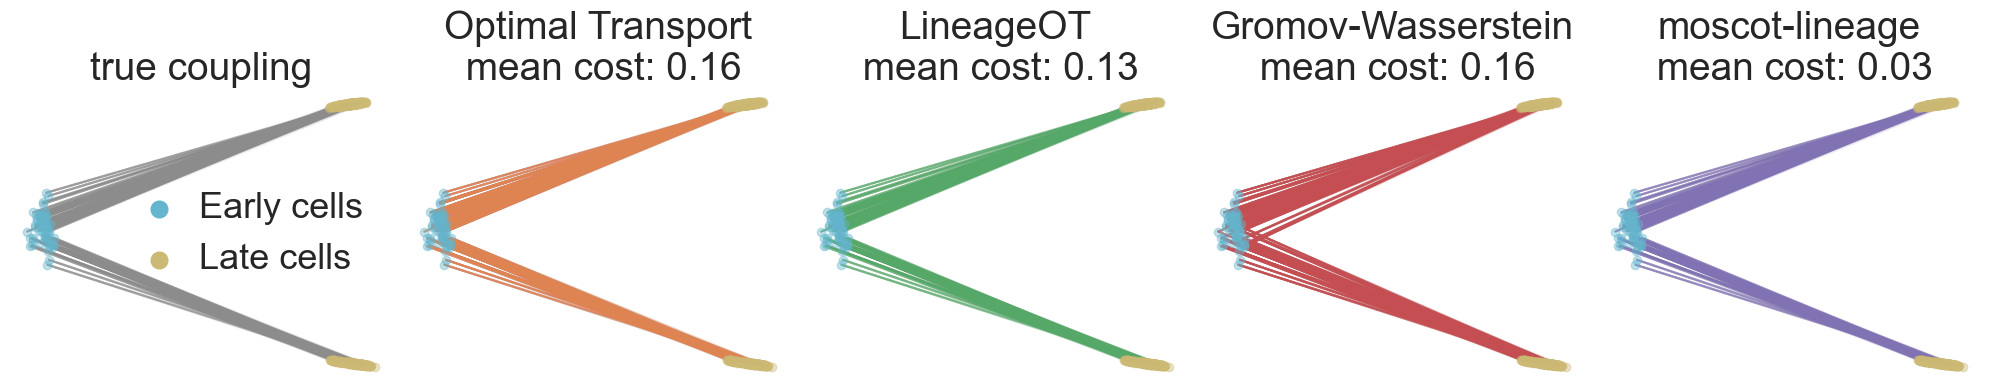

In [16]:
rows = 1
cols = 5
size = 4

palette= sns.color_palette("deep")
colors = [palette[-1], palette[-2]]
titles = ['true coupling', 'Optimal Transport', 'LineageOT','Gromov-Wasserstein', 'moscot-lineage']
fig, axs = plt.subplots(rows, cols, figsize=(cols*(size),rows*(size)))


for i, coup in enumerate(coups):
    for a,label, c in zip([sim.rna_arrays['early'], sim.rna_arrays['late']], ['Early cells', 'Late cells'], colors):
        axs[i].scatter(a[:, sim.dimensions_to_plot[0]], a[:, sim.dimensions_to_plot[1]], alpha = 0.4, 
                        label = label, color = c, zorder=10)

    plot2D_samples_mat(sim.rna_arrays['early'][:, [sim.dimensions_to_plot[0],sim.dimensions_to_plot[1]]],
                       sim.rna_arrays['late'][:, [sim.dimensions_to_plot[0],sim.dimensions_to_plot[1]]],
                       coup,
                       c=palette[-3] if i==0 else palette[i],
                       alpha_scale = 0.1, ax=axs[i], thr=1e-3)

    axs[i].set_xlabel('Gene ' + str(sim.dimensions_to_plot[0] + 1))
    axs[i].set_ylabel('')
    if i == 0:
        axs[i].set_ylabel('Gene ' + str(sim.dimensions_to_plot[1] + 1))
        lge = axs[i].legend(fontsize=26, frameon=False, markerscale=2, 
                            handlelength=1, handletextpad=0.6, borderaxespad=.4, columnspacing=.6, loc='center right')
        for lh in lge.legendHandles: 
            lh.set_alpha(1)
        axs[i].set_title(titles[i], fontsize=28)
    else:
        axs[i].set_title(f'{titles[i]}\n mean cost: {np.round(costs[i], 2)}', fontsize=28)
    axs[i].axis('Off')


plt.tight_layout()
plt.show()